In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import mean_squared_error

import holidays
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')

In [9]:
train = pd.read_csv(r'./data/train.csv')
international_trade = pd.read_csv(r'./data/international_trade.csv')
test = pd.read_csv(r'./data/test.csv')

In [10]:
def group_season(df):
    df.loc[(df['month'] == 3) | (df['month'] == 4) | (df['month'] == 5), 'season'] = '봄'
    df.loc[(df['month'] == 6) | (df['month'] == 7) | (df['month'] == 8), 'season'] = '여름'
    df.loc[(df['month'] == 9) | (df['month'] == 10) | (df['month'] == 11), 'season'] = '가을'
    df.loc[(df['month'] == 12) | (df['month'] == 1) | (df['month'] == 2), 'season'] = '겨울'
    return df['season']

def holiday(df):
    kr_holidays = holidays.KR()
    df['holiday'] = df.timestamp.apply(lambda x: 'holiday' if x in kr_holidays else 'non-holiday')
    return df['holiday']

def cyclical_feature(df, time=12):
    df['sin_time'] = np.sin(2*np.pi*df.month/time)
    df['cos_time'] = np.cos(2*np.pi*df.month/time)
    
def post_preprocessing(test, submission):
    idx_list = test[(test['Weekday'] == 6)].index 
    submission.loc[idx_list, 'answer'] = 0 # Weekday == 6 (일요일)이면 가격 0원
    submission['answer'] = submission['answer'].apply(lambda x: max(0, x)) # 가격에 음수가 있다면 가격 0원으로 변경
    return submission

In [11]:
train['year'] = train['timestamp'].apply(lambda x : int(x[0:4]))
train['month'] = train['timestamp'].apply(lambda x : int(x[5:7]))
train['day'] = train['timestamp'].apply(lambda x : int(x[8:10]))
train['Weekday'] = pd.to_datetime(train['timestamp']).dt.weekday
train['is_weekend'] = train['Weekday'].apply(lambda x: 1 if x >= 6 else 0)
train['total_item_value'] = train['item']+train['corporation']+train['location']
train['item_month_Weekday'] = train['item'].astype(str) + "_" + train['month'].astype(str) + train['Weekday'].astype(str)
train['item_corp_Weekday'] = train['item'].astype(str) + "_" + train['corporation'].astype(str) + train['Weekday'].astype(str)
train['item_location_Weekday'] = train['item'].astype(str) + "_" + train['location'].astype(str) + train['Weekday'].astype(str)

cyclical_feature(train)

test['year'] = test['timestamp'].apply(lambda x : int(x[0:4]))
test['month'] = test['timestamp'].apply(lambda x : int(x[5:7]))
test['day'] = test['timestamp'].apply(lambda x : int(x[8:10]))
test['Weekday'] = pd.to_datetime(test['timestamp']).dt.weekday
test['is_weekend'] = test['Weekday'].apply(lambda x: 1 if x >= 6 else 0)
test['total_item_value'] = test['item']+test['corporation']+test['location']
test['item_month_Weekday'] = test['item'].astype(str) + "_" + test['month'].astype(str) + test['Weekday'].astype(str)
test['item_corp_Weekday'] = test['item'].astype(str) + "_" + test['corporation'].astype(str) + test['Weekday'].astype(str)
test['item_location_Weekday'] = test['item'].astype(str) + "_" + test['location'].astype(str) + test['Weekday'].astype(str)

cyclical_feature(test)


train['season'] = group_season(train)
test['season'] = group_season(test)

train['holiday'] = holiday(train)
test['holiday'] = holiday(test)


train['item_year_season'] = train['item'].astype(str) + "_" + train['year'].astype(str) + "_" + train['season'].astype(str)
test['item_year_season'] = test['item'].astype(str) + "_" + test['year'].astype(str) + "_" + test['season'].astype(str)
train.loc[(train['Weekday'] == 6) & (train['price(원/kg)'] >= 0), 'price(원/kg)'] = 0


im_mean = train.groupby(['item', 'month'])['price(원/kg)'].agg([('im_mean', 'median')]).reset_index()
train = pd.merge(train, im_mean, on=['item', 'month'], how='left')
test = pd.merge(test, im_mean, on=['item', 'month'], how='left')


iw_mean = train.groupby(['item', 'corporation'])['price(원/kg)'].agg([('iw_mean', 'median')]).reset_index()
train = pd.merge(train, iw_mean, on=['item', 'corporation'], how='left')
test = pd.merge(test, iw_mean, on=['item', 'corporation'], how='left')


im_std = train.groupby(['item', 'month'])['price(원/kg)'].agg([('std', 'median')]).reset_index()
train = pd.merge(train, im_std, on=['item', 'month'], how='left')
test = pd.merge(test, im_std, on=['item', 'month'], how='left')


iw_std = train.groupby(['item', 'corporation'])['price(원/kg)'].agg([('std_ic', 'median')]).reset_index()
train = pd.merge(train, iw_std, on=['item', 'corporation'], how='left')
test = pd.merge(test, iw_std, on=['item', 'corporation'], how='left')

x = train.drop(columns=['ID', 'timestamp', 'supply(kg)', 'price(원/kg)'])
y = train['price(원/kg)']

x_test = test.drop(columns=['ID', 'timestamp'])

qual_col = ['item', 'corporation', 'location', 'season', 'holiday', 'total_item_value',
            'item_month_Weekday', 'item_corp_Weekday', 'item_location_Weekday', 'item_year_season']

for i in qual_col:      
    le = LabelEncoder()
    x[i]=le.fit_transform(x[i])
    x_test[i]=le.transform(x_test[i])

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=1103)

RMSE: 872.5688245384166
Round RMSE: 872.5676181433295


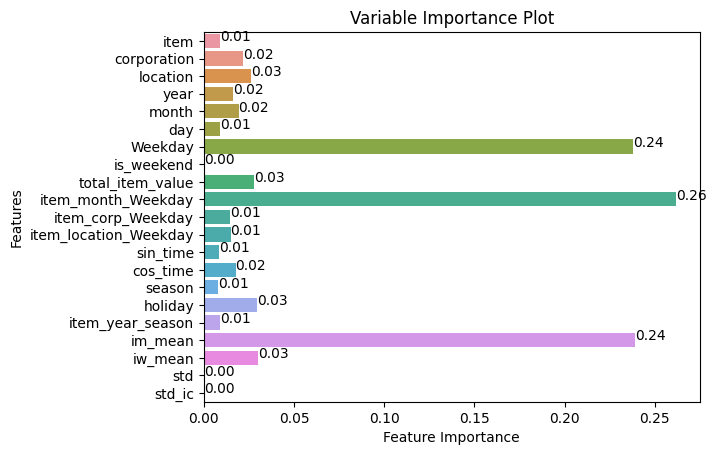

In [12]:
xgb = XGBRegressor()
xgb.fit(x_train, y_train)
xgb_pred = xgb.predict(x_val)
rmse = mean_squared_error(y_val, xgb_pred, squared=False)
round_rmse = mean_squared_error(y_val, np.round(xgb_pred), squared=False)
print(f"RMSE: {rmse}")
print(f"Round RMSE: {round_rmse}")

feature_importance = xgb.feature_importances_
for index, value in enumerate(feature_importance):
    plt.text(value, index, f'{value:.2f}')  # 소수점 둘째 자리까지 표시
sns.barplot(x=feature_importance, y=x_train.columns)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Variable Importance Plot')
plt.show()

In [13]:
def cross_validate_models(folds, X, y, model, mode='xgb'):

    models = []
    scores = []
    
    for idx, (train_idx, val_idx) in enumerate(folds):
        print(f'===================================={idx+1}============================================')
        x_train, x_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        if mode == 'xgb':
            model.fit(x_train, y_train, early_stopping_rounds=50, eval_metric='rmse', eval_set=[(x_val, y_val)], verbose=False)
        if mode == 'lgbm':
            model.fit(x_train, y_train, early_stopping_rounds=50, eval_metric='rmse', eval_set=[(x_val, y_val)], verbose=False)
        if mode == 'cat':
            model.fit(x_train, y_train, early_stopping_rounds=50, verbose=100)
        y_pred = model.predict(x_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        print(f"{idx + 1} Fold RMSE = {rmse}")
        
        scores.append(rmse)
        models.append(model)
        print(f'================================================================================\n\n')
    
    print(f"Average RMSE over {len(folds)} folds: {sum(scores)/len(folds):.4f}")
    
    return models

model = XGBRegressor(n_estimators=10000, random_state=1103)
# model = LGBMRegressor(n_estimators=10000, random_state=1103)
# model = CatBoostRegressor(n_estimators=10000, random_state=1103, cat_features=qual_col)
folds = list(StratifiedKFold(n_splits=5, shuffle=True, random_state=1103).split(x, y))
models = cross_validate_models(folds, x, y, model, 'xgb')
predictions = sum(model.predict(x_test) for model in models) / len(folds)

====================================1============================================
1 Fold RMSE = 854.6159698005491


====================================2============================================
2 Fold RMSE = 854.7159175789151


====================================3============================================
3 Fold RMSE = 875.9002388988481


====================================4============================================
4 Fold RMSE = 871.7084876467646


====================================5============================================
5 Fold RMSE = 849.9805957916852


Average RMSE over 5 folds: 861.3842


In [14]:
predictions

array([3656.4226  ,  -26.797913, 3111.315   , ...,  513.4063  ,
        510.5634  ,  505.99063 ], dtype=float32)

In [136]:
submission = pd.read_csv(r'data\sample_submission.csv')
submission['answer'] = np.round(predictions)
submission = post_preprocessing(x_test, submission)
submission.to_csv('./xgb_submission.csv', index=False)

In [107]:
# idx_list = x_test[(x_test['Weekday'] == 6)].index
# submission.loc[idx_list, 'answer'] = 0
# submission['answer'] = submission['answer'].apply(lambda x: max(0, x))